<a href="https://colab.research.google.com/github/Galeano-Garcia-GS/Synergistic-SCFA-production-by-Fiber-Mixture/blob/main/New_insights_into_synergistic_boosts_in_SCFA_production_across_health_conditions_induced_by_a_fiber_mixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New insights into synergistic boosts in SCFA production across health conditions induced by a fiber mixture

$G.\ S.\ Galeano\text{-}Garcia^{1,2},\ T.\ Chen^{3},\ P.\ A.\ Engen^{4},\
A.\ Keshavarzian^{4,5,6,7},\ B.\ R.\ Hamaker^{1,2},\
T.\ M.\ Cantu\text{-}Jungles^{1,2,*}$


In [1]:
# @markdown Clone GitHub repository by running this cell.

repository = 'https://github.com/Galeano-Garcia-GS/Synergistic-SCFA-production-by-Fiber-Mixture'  # @param {type: "string"}

!git clone {repository}
!cd /content/Synergistic-SCFA-production-by-Fiber-Mixture/

Cloning into 'Synergistic-SCFA-production-by-Fiber-Mixture'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 85 (delta 32), reused 1 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (85/85), 1.84 MiB | 9.35 MiB/s, done.
Resolving deltas: 100% (32/32), done.


## Figures 1, 2 and S1: Synergy calculation

In [8]:
#@title ### Dataframe

install_dependencies = False  #@param {type:"boolean"}
excel_file_path = "/content/Synergistic-SCFA-production-by-Fiber-Mixture/Metadata.xlsx"  #@param {type:"string"}
sheet_name = "Full"  #@param {type:"string"}
columns_csv = "Individual, Replicate, Fiber, Acetate_(mM), Expected_acetate_(mM), Butyrate_(mM), Expected_butyrate_(mM), Propionate_(mM), Expected_propionate_(mM), Total_SCFA_(mM), Expected_total_SCFA_(mM)"  #@param {type:"string"}
enable_filtering = True  #@param {type:"boolean"}

output_directory = "/content"  #@param {type:"string"}
output_filename = "Metadata_V1.xlsx"  #@param {type:"string"}
create_directory_if_missing = True  #@param {type:"boolean"}
save_format = "Excel (.xlsx)"  #@param ["Excel (.xlsx)", "CSV (.csv)"]
include_index = False  #@param {type:"boolean"}

import sys, subprocess, os
if install_dependencies:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pandas", "openpyxl"])

import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets

if not os.path.exists(excel_file_path):
    raise FileNotFoundError(f"File not found: {excel_file_path}")

raw_df = pd.read_excel(excel_file_path, sheet_name=sheet_name, header=None)
headers = raw_df.iloc[0].tolist()
types = raw_df.iloc[1].tolist()
data = raw_df.iloc[2:].reset_index(drop=True)
data.columns = headers

selected_columns = [c.strip() for c in columns_csv.split(",") if c.strip()] or headers
missing = [c for c in selected_columns if c not in headers]
if missing:
    raise KeyError(f"Columns not found: {missing}\nAvailable: {headers}")

df_selected = data[selected_columns].copy()
display(HTML("<h4>Preview of selected columns</h4>"))
display(df_selected.head())
print(f"Shape: {df_selected.shape}")

type_map = dict(zip(headers, types))
categorical_cols = [c for c in selected_columns if str(type_map.get(c, "")).lower() == "categorical"]

filter_widgets = {}
clear_buttons = {}

if enable_filtering and categorical_cols:
    display(HTML("<h4>Filters for categorical columns</h4>"))
    cols_ui = []
    for col in categorical_cols:
        unique_vals = df_selected[col].dropna().unique().tolist()
        has_nans = df_selected[col].isna().any()

        ms = widgets.SelectMultiple(options=unique_vals, description=col, layout=widgets.Layout(width="60%"))
        nan_toggle = widgets.Checkbox(value=False, description="Include missing") if has_nans else None
        clear_btn = widgets.Button(description="Clear", button_style="warning", icon="x")

        def make_clear_handler(ms_widget, nan_widget):
            def _handler(_):
                ms_widget.value = ()
                if nan_widget is not None:
                    nan_widget.value = False
            return _handler

        clear_btn.on_click(make_clear_handler(ms, nan_toggle))
        row = widgets.HBox([ms, widgets.VBox(([nan_toggle] if nan_toggle else [])), clear_btn])
        cols_ui.append(row)

        filter_widgets[col] = {"widget": ms, "nan": nan_toggle}
        clear_buttons[col] = clear_btn

    display(widgets.VBox(cols_ui))

apply_button = widgets.Button(description="Apply Filters & Save", button_style="primary", icon="check")
clear_all_button = widgets.Button(description="Clear All Filters", icon="trash")
buttons_bar = widgets.HBox([apply_button, clear_all_button])

output_area = widgets.Output()
display(buttons_bar, output_area)

def clear_all(_):
    for parts in filter_widgets.values():
        parts["widget"].value = ()
        if parts["nan"] is not None:
            parts["nan"].value = False

def apply_filters_and_save(_):
    with output_area:
        output_area.clear_output()
        df_filtered = df_selected.copy()
        if enable_filtering and filter_widgets:
            for col, parts in filter_widgets.items():
                chosen = list(parts["widget"].value)
                include_nan = parts["nan"].value if parts["nan"] else False
                if chosen or include_nan:
                    mask = df_filtered[col].isin(chosen)
                    if include_nan: mask |= df_filtered[col].isna()
                    df_filtered = df_filtered[mask]
        display(HTML("<h4>Final DataFrame</h4>"))
        display(df_filtered)
        print(f"Final shape: {df_filtered.shape}")
        if create_directory_if_missing and not os.path.exists(output_directory):
            os.makedirs(output_directory, exist_ok=True)
        out_path = os.path.join(output_directory, output_filename)
        if save_format.startswith("Excel"):
            if not out_path.lower().endswith(".xlsx"): out_path += ".xlsx"
            df_filtered.to_excel(out_path, index=include_index)
        else:
            if not out_path.lower().endswith(".csv"): out_path += ".csv"
            df_filtered.to_csv(out_path, index=include_index)
        display(HTML(f"<b>Saved to:</b> <code>{out_path}</code>"))

clear_all_button.on_click(clear_all)
apply_button.on_click(apply_filters_and_save)

,Individual,Replicate,Fiber,Acetate_(mM),Expected_acetate_(mM),Butyrate_(mM),Expected_butyrate_(mM),Propionate_(mM),Expected_propionate_(mM),Total_SCFA_(mM),Expected_total_SCFA_(mM)
0,C01,1,FOS,4.264,NaN,2.285,NaN,3.466,NaN,10.015,NaN
1,C01,2,FOS,3.717,NaN,1.985,NaN,3.032,NaN,8.734,NaN
2,C01,1,β-Glucan,6.708,NaN,2.039,NaN,3.079,NaN,11.826,NaN
3,C01,2,β-Glucan,2.425,NaN,2.021,NaN,2.983,NaN,7.43,NaN
4,C01,1,Pectin,7.166,NaN,1.373,NaN,2.314,NaN,10.853,NaN


Shape: (408, 11)


Output()

In [9]:
#@title ### Calculating synergy
import pandas as pd
import numpy as np

# ---- Load data ----
metadata_file_path = "Metadata_V1.xlsx"  #@param {type:"string"}
df = pd.read_excel(metadata_file_path)

# ---- Column handles ----
observed_column = "Acetate_(mM)"  #@param ["Acetate_(mM)", "Butyrate_(mM)", "Propionate_(mM)", "Total_SCFA_(mM)"]
expected_column = "Expected_acetate_(mM)"  #@param ["Expected_acetate_(mM)", "Expected_butyrate_(mM)", "Expected_propionate_(mM)", "Expected_total_SCFA_(mM)"]

# ---- Tunable parameters (Colab form fields) ----
measurement_error = 0.5  #@param {type:"slider", min:0.0, max:1.0, step:0.01}
minimal_detection_limit = 1  #@param {type:"slider", min:0.0, max:1.0, step:0.01}

# Convert to numeric safely
for c in [observed_column, expected_column]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- Gating rules ----
diff = df[observed_column].sub(df[expected_column]).abs()
gate_mdl = (df[observed_column] >= minimal_detection_limit) & (df[expected_column] >= minimal_detection_limit)
gate_me = (diff > measurement_error)  # keep your original strict '>' rule
gate_nonzero = df[expected_column] != 0
mask_valid = gate_mdl & gate_me & gate_nonzero

# ---- Prepare output ----
synergy_col = f"Synergy_in_{observed_column}" + "_(%)"
out = df[["Individual", "Replicate", observed_column, expected_column]].copy()

# Calculate synergy only where valid; otherwise NaN for now
out[synergy_col] = np.where(
    mask_valid,
    ((df[observed_column] - df[expected_column]) / df[expected_column]) * 100,
    np.nan
)

synergy_category = f"{observed_column}" + "_synergy_category"

# Create category column with object dtype first
out[synergy_category] = pd.Series(index=out.index, dtype="object")
out.loc[out[synergy_col] >= 0, synergy_category] = "Positive"
out.loc[out[synergy_col] < 0, synergy_category] = "Negative"

# ---- Apply requested exclusions behavior ----
# If excluded ONLY due to measurement_error -> set synergy to 0
fail_me = ~gate_me
fail_mdl = ~gate_mdl
me_only = (~mask_valid) & fail_me & (~fail_mdl) & gate_nonzero
out.loc[me_only, synergy_col] = 0.0

# Reason of exclusion column
reason_col = f"Reason_of_exclusion_{synergy_category}"
out[reason_col] = pd.Series(index=out.index, dtype="object")
out.loc[fail_mdl & fail_me, reason_col] = "minimal_detection_limit and measurement_error"
out.loc[fail_mdl & ~fail_me, reason_col] = "minimal_detection_limit"
out.loc[(~fail_mdl) & fail_me, reason_col] = "measurement_error"
# rows that are valid remain NaN (blank in Excel)

# Round synergy for readability
out[synergy_col] = out[synergy_col].round(3)

# NEW: If synergy == 0, set category to "No_synergy"
out.loc[out[synergy_col] == 0, synergy_category] = "No_synergy"

# Final column order (original order + reason column at the end)
out = out[["Individual", "Replicate", observed_column, expected_column, synergy_col, synergy_category, reason_col]]

# ---- Save & display ----
save_path = f"/content/{observed_column}_synergy_results.xlsx"
out.to_excel(save_path, index=False)

print(f"Input rows: {len(df)}")
print(f"Rows with synergy calculated: {mask_valid.sum()}")
print(f"Saved to: {save_path}")
out.head(10)

Input rows: 68
Rows with synergy calculated: 66
Saved to: /content/Acetate_(mM)_synergy_results.xlsx


,Individual,Replicate,Acetate_(mM),Expected_acetate_(mM),Synergy_in_Acetate_(mM)_(%),Acetate_(mM)_synergy_category,Reason_of_exclusion_Acetate_(mM)_synergy_category
0,C01,1,11.065,5.9610,85.623,Positive,NaN
1,C01,2,13.489,5.8805,129.385,Positive,NaN
2,C02,1,12.491,8.3490,49.611,Positive,NaN
3,C02,2,15.209,7.8830,92.934,Positive,NaN
4,C03,1,8.551,6.1110,39.928,Positive,NaN
5,C03,2,8.186,5.5910,46.414,Positive,NaN
6,C04,1,8.763,7.4260,18.004,Positive,NaN
7,C04,2,10.534,7.2520,45.256,Positive,NaN
8,C05,1,2.674,3.5750,-25.203,Negative,NaN
9,C05,2,3.351,3.6500,0.000,No_synergy,measurement_error


## Figure 3a: q2-ANCOM-BC

In [10]:
# @markdown Download feature table file by running this cell.

working_directory = "/scratch/bell/ggaleano/ANCOM" #@param {type:"string"}
metadata_file_name = "metadata.tsv"  #@param {type:"string"}
feature_table_tsv_file_name = "feature-table-species-level.tsv"  #@param {type:"string"}
formula_column = "Acetate_synergy_category"  #@param {type:"string"}
reference_levels = "No_synergy"  #@param {type:"string"}

print(
f"""
ssh ggaleano@bell.rcac.purdue.edu

scp {metadata_file_name} ggaleano@bell.rcac.purdue.edu:{working_directory}

cd /scratch/bell/ggaleano/ANCOM

squeue -A hamakerb
sinteractive -A hamakerb -p cpu -t 2:00:00 -n8

module --force purge
module load biocontainers qiime2
module list

qiime metadata tabulate \\
  --m-input-file {metadata_file_name} \\
  --o-visualization metadata.qzv

scp ggaleano@bell.rcac.purdue.edu:{working_directory}/*.qzv .

scp {feature_table_tsv_file_name} ggaleano@bell.rcac.purdue.edu:{working_directory}

biom convert \\
  -i {feature_table_tsv_file_name} \\
  -o feature-table.biom \\
  --table-type="OTU table" \\
  --to-hdf5

qiime tools import \\
  --type 'FeatureTable[Frequency]' \\
  --input-format BIOMV210Format \\
  --input-path feature-table.biom \\
  --output-path feature-table.qza

qiime composition ancombc \\
  --i-table feature-table.qza \\
  --m-metadata-file metadata.tsv \\
  --p-formula '{formula_column}' \\
  --p-reference-levels '{formula_column}::{reference_levels}' \\
  --o-differentials {formula_column}_R_{reference_levels}.qza

qiime composition da-barplot \\
  --i-data {formula_column}_R_{reference_levels}.qza \\
  --p-significance-threshold 0.05 \\
  --o-visualization {formula_column}_R_{reference_levels}.qzv

scp ggaleano@bell.rcac.purdue.edu:{working_directory}/*.qzv .

"""
)


ssh ggaleano@bell.rcac.purdue.edu

scp metadata.tsv ggaleano@bell.rcac.purdue.edu:/scratch/bell/ggaleano/ANCOM

cd /scratch/bell/ggaleano/ANCOM

squeue -A hamakerb
sinteractive -A hamakerb -p cpu -t 2:00:00 -n8

module --force purge
module load biocontainers qiime2
module list

qiime metadata tabulate \
  --m-input-file metadata.tsv \
  --o-visualization metadata.qzv

scp ggaleano@bell.rcac.purdue.edu:/scratch/bell/ggaleano/ANCOM/*.qzv .

scp feature-table-species-level.tsv ggaleano@bell.rcac.purdue.edu:/scratch/bell/ggaleano/ANCOM

biom convert \
  -i feature-table-species-level.tsv \
  -o feature-table.biom \
  --table-type="OTU table" \
  --to-hdf5

qiime tools import \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --input-path feature-table.biom \
  --output-path feature-table.qza

qiime composition ancombc \
  --i-table feature-table.qza \
  --m-metadata-file metadata.tsv \
  --p-formula 'Acetate_synergy_category' \
  --p-reference-levels 'Acetate_syner

## Figure 3b

In [28]:
#@title ### Dataframe

install_dependencies = False  #@param {type:"boolean"}
excel_file_path = "/content/Synergistic-SCFA-production-by-Fiber-Mixture/Metadata.xlsx"  #@param {type:"string"}
sheet_name = "Full"  #@param {type:"string"}

columns_csv = "Individual,Replicate,Fiber,Synergy_in_acetate_(%),Synergy_in_butyrate_(%),Synergy_in_propionate_(%),Synergy_in_total_SCFA_(%),shannon_entropy,observed_features,pielou_evenness,∆_shannon_entropy,∆_observed_features,∆_pielou_evenness,Initial_shannon_entropy,Initial_observed_features,Initial_pielou_evenness"  #@param {type:"string"}

enable_filtering = True  #@param {type:"boolean"}

# Free-text filter syntax, e.g. Fiber==Mixture, FOS, Individual==C01
filter_query = "Fiber==Mixture, FOS"  # @param {type:"string"}

output_directory = "/content"  #@param {type:"string"}
output_filename = "Metadata_V1.xlsx"  #@param {type:"string"}
create_directory_if_missing = True  #@param {type:"boolean"}
save_format = "Excel (.xlsx)"  #@param ["Excel (.xlsx)", "CSV (.csv)"]
include_index = False  #@param {type:"boolean"}

import sys, subprocess, os
if install_dependencies:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pandas", "openpyxl"])

import pandas as pd
from IPython.display import display, HTML

# ---------- Load data ----------

if not os.path.exists(excel_file_path):
    raise FileNotFoundError(f"File not found: {excel_file_path}")

raw_df = pd.read_excel(excel_file_path, sheet_name=sheet_name, header=None)
headers = raw_df.iloc[0].tolist()
types = raw_df.iloc[1].tolist()
data = raw_df.iloc[2:].reset_index(drop=True)
data.columns = headers

# Which columns to show in the output (filter can use ANY column in `data`)
selected_columns = [c.strip() for c in columns_csv.split(",") if c.strip()] or headers
missing = [c for c in selected_columns if c not in headers]
if missing:
    raise KeyError(f"Columns not found: {missing}\nAvailable: {headers}")

df_selected = data[selected_columns].copy()

display(HTML("<h4>Preview of selected columns (unfiltered)</h4>"))
display(df_selected.head())
print(f"Original shape (selected columns): {df_selected.shape}")

# ---------- Text filter parser ----------

def apply_text_filter(df: pd.DataFrame, query: str) -> pd.DataFrame:
    """
    Syntax examples:
      - 'Fiber==Mixture' -> Fiber == 'Mixture'
      - 'Fiber==Mixture, FOS' -> Fiber in {'Mixture', 'FOS'}
      - 'Fiber==Mixture, Individual==C01' -> Fiber=='Mixture' & Individual=='C01'
      - 'Individual==C01, C02' -> Individual in {'C01', 'C02'}
    You can use ANY column name from the sheet.
    """
    query = str(query).strip()

    # Remove accidental surrounding quotes like "Fiber==Mixture, FOS"
    if (query.startswith('"') and query.endswith('"')) or (query.startswith("'") and query.endswith("'")):
        query = query[1:-1].strip()

    if not query:
        return df

    clauses = [c.strip() for c in query.split(",") if c.strip()]
    col_to_values = {}
    current_col = None

    for clause in clauses:
        if "==" in clause:
            col, val = clause.split("==", 1)
            current_col = col.strip()
            if current_col not in df.columns:
                raise KeyError(
                    f"Unknown column in filter: '{current_col}'. "
                    f"Available columns: {list(df.columns)}"
                )
            val = val.strip()
            col_to_values.setdefault(current_col, set()).add(val)
        else:
            # Extra value for the last column mentioned
            if current_col is None:
                raise ValueError(
                    f"Filter value '{clause}' has no associated column. "
                    f"Start with 'Column==Value', e.g. 'Fiber==Mixture, FOS'."
                )
            val = clause.strip()
            col_to_values.setdefault(current_col, set()).add(val)

    # Start with all rows = True
    mask = pd.Series(True, index=df.index)

    for col, values in col_to_values.items():
        # Compare as strings so it works for categorical/object columns
        mask &= df[col].astype(str).isin(values)

    return df[mask]

# ---------- Apply filter immediately ----------

if enable_filtering and str(filter_query).strip():
    # Filter using ALL columns in `data` (so you can filter by any column)
    filtered_full = apply_text_filter(data, filter_query)
else:
    filtered_full = data

# Only keep the selected columns in the final output
df_filtered = filtered_full[selected_columns].copy()

display(HTML("<h4>Final DataFrame (after text filter)</h4>"))
display(df_filtered)
print(f"Final shape: {df_filtered.shape}")

# ---------- Save to file ----------

if create_directory_if_missing and not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

out_path = os.path.join(output_directory, output_filename)

if save_format.startswith("Excel"):
    if not out_path.lower().endswith(".xlsx"):
        out_path += ".xlsx"
    df_filtered.to_excel(out_path, index=include_index)
else:
    if not out_path.lower().endswith(".csv"):
        out_path += ".csv"
    df_filtered.to_csv(out_path, index=include_index)

display(HTML(f"<b>Saved to:</b> <code>{out_path}</code>"))

,Individual,Replicate,Fiber,Synergy_in_acetate_(%),Synergy_in_butyrate_(%),Synergy_in_propionate_(%),Synergy_in_total_SCFA_(%),shannon_entropy,observed_features,pielou_evenness,∆_shannon_entropy,∆_observed_features,∆_pielou_evenness,Initial_shannon_entropy,Initial_observed_features,Initial_pielou_evenness
0,C01,1,FOS,NaN,NaN,NaN,NaN,2.249454,186,0.298369,NaN,NaN,NaN,NaN,NaN,NaN
1,C01,2,FOS,NaN,NaN,NaN,NaN,2.873844,109,0.424611,NaN,NaN,NaN,NaN,NaN,NaN
2,C01,1,β-Glucan,NaN,NaN,NaN,NaN,2.609212,204,0.340077,NaN,NaN,NaN,NaN,NaN,NaN
3,C01,2,β-Glucan,NaN,NaN,NaN,NaN,3.371535,120,0.488141,NaN,NaN,NaN,NaN,NaN,NaN
4,C01,1,Pectin,NaN,NaN,NaN,NaN,3.443752,207,0.447619,NaN,NaN,NaN,NaN,NaN,NaN


Original shape (selected columns): (408, 16)


,Individual,Replicate,Fiber,Synergy_in_acetate_(%),Synergy_in_butyrate_(%),Synergy_in_propionate_(%),Synergy_in_total_SCFA_(%),shannon_entropy,observed_features,pielou_evenness,∆_shannon_entropy,∆_observed_features,∆_pielou_evenness,Initial_shannon_entropy,Initial_observed_features,Initial_pielou_evenness
0,C01,1,FOS,NaN,NaN,NaN,NaN,2.249454,186,0.298369,NaN,NaN,NaN,NaN,NaN,NaN
1,C01,2,FOS,NaN,NaN,NaN,NaN,2.873844,109,0.424611,NaN,NaN,NaN,NaN,NaN,NaN
8,C01,1,Mixture,85.623,48.469,0,60.264,3.072385,190,0.405871,1.617767,179,0.144134,4.690151,369,0.550005
9,C01,2,Mixture,129.385,45.704,24.49,84.839,3.430312,117,0.499291,1.151469,57,0.116296,4.581781,174,0.615587
10,C02,1,FOS,NaN,NaN,NaN,NaN,4.276237,275,0.527716,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,U06,2,Mixture,0,8.694,NaN,0,4.065099,105,0.605444,1.794085,304,0.069892,5.859183,409,0.675336
330,U07,1,FOS,NaN,NaN,NaN,NaN,4.591107,187,0.608344,NaN,NaN,NaN,NaN,NaN,NaN
331,U07,2,FOS,NaN,NaN,NaN,NaN,4.543652,192,0.599034,NaN,NaN,NaN,NaN,NaN,NaN
338,U07,1,Mixture,6.191,22.028,0,7.68,4.592,211,0.594734,0.419333,29,0.039059,5.011333,240,0.633793


Final shape: (136, 16)


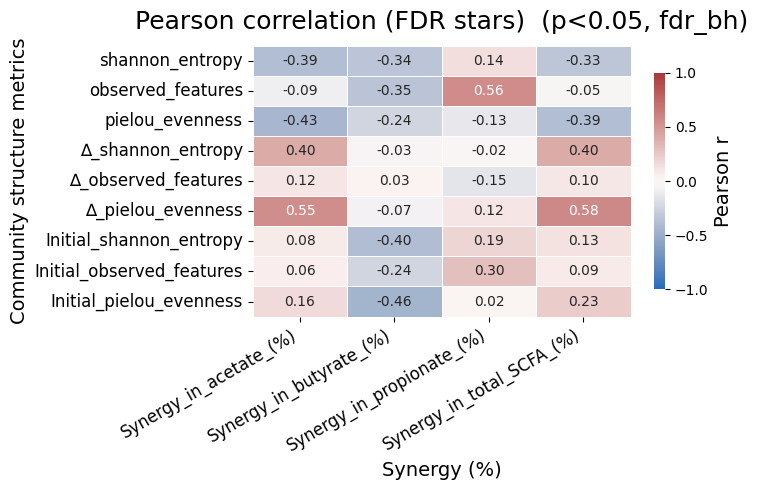

In [29]:
#@title ### Plot
#@markdown **How to use:**
#@markdown 1) Set the **file path** and your **Y (rows)** and **X (columns)**.
#@markdown 2) Tweak significance, masking, colors, **font sizes**, and export options.
#@markdown 3) (Optional) aggregate replicates (e.g., by `Individual`) before correlating.
#@markdown 4) Run to render and (optionally) save CSVs/figure.

# ===================== Input / selection =====================
file_path = "Metadata_V1.xlsx"  #@param {type:"string"}
y_cols = "shannon_entropy,observed_features,pielou_evenness,∆_shannon_entropy,∆_observed_features,∆_pielou_evenness,Initial_shannon_entropy,Initial_observed_features,Initial_pielou_evenness"  #@param {type:"string"}
x_cols = "Synergy_in_acetate_(%), Synergy_in_butyrate_(%), Synergy_in_propionate_(%), Synergy_in_total_SCFA_(%)"  #@param {type:"string"}

# Optional pre-aggregation of replicates
groupby_cols = "Individual"  #@param {type:"string"}
agg_method = "mean"  #@param ["mean", "median"]

# ===================== Significance & annotation =====================
p_correction = "fdr_bh"  #@param ["none","fdr_bh","bonferroni","holm","sidak"]
p_thresh = 0.05  #@param {type:"slider", min:0.0, max:0.25, step:0.005}
annotate = "both"  #@param ["none","coef","stars","both"]
annot_decimals = 2  #@param {type:"slider", min:0, max:4, step:1}

from scipy.cluster.hierarchy import linkage, leaves_list
# ===================== Clustering options =====================
cluster_rows = False  #@param {type:"boolean"}
cluster_cols = False  #@param {type:"boolean"}

# ===================== Masking options =====================
mask_nonsignificant = False  #@param {type:"boolean"}
mask_upper_triangle = False  #@param {type:"boolean"}
mask_lower_triangle = False  #@param {type:"boolean"}
mask_diagonal = False  #@param {type:"boolean"}

# ===================== Plot appearance =====================
# Colormap list kept short; feel free to expand
cmap = "vlag"  #@param ["vlag","coolwarm","RdBu_r","viridis","magma","rocket","crest","icefire"]
fig_width = 7.5  #@param {type:"slider", min:4.0, max:20.0, step:0.5}
fig_height = 5  #@param {type:"slider", min:3.0, max:20.0, step:0.5}
vmin = -1  #@param {type:"slider", min:-1.0, max:0.0, step:0.05}
vmax = 1.0  #@param {type:"slider", min:0.0, max:1.0, step:0.05}
center_zero = True  #@param {type:"boolean"}
robust = False  #@param {type:"boolean"}
alpha = 1  #@param {type:"slider", min:0.1, max:1.0, step:0.05}
linewidths = 0.5  #@param {type:"slider", min:0.0, max:2.0, step:0.1}
linecolor = "white"  #@param ["white","black","#DDDDDD","#333333"]
square = False  #@param {type:"boolean"}

# ===================== Fonts & labels =====================
title_text = "Pearson correlation (FDR stars)"  #@param {type:"string"}
title_fontsize = 18  #@param {type:"slider", min:8, max:36, step:1}
axislabel_fontsize = 14  #@param {type:"slider", min:8, max:30, step:1}
ticklabel_fontsize = 12  #@param {type:"slider", min:6, max:26, step:1}
annot_fontsize = 10  #@param {type:"slider", min:6, max:26, step:1}
xtick_rotation = 30  #@param {type:"slider", min:0, max:90, step:5}
ytick_rotation = 0  #@param {type:"slider", min:-90, max:90, step:5}

# ===================== Colorbar =====================
show_colorbar = True  #@param {type:"boolean"}
cbar_label = "Pearson r"  #@param {type:"string"}
cbar_shrink = 0.8  #@param {type:"slider", min:0.4, max:1.0, step:0.05}
cbar_aspect = 20  #@param {type:"slider", min:5, max:40, step:1}
cbar_ticklabelsize = 10  #@param {type:"slider", min:6, max:26, step:1}

# ===================== Save outputs =====================
output_csv_prefix = ""  #@param {type:"string"}
savefig_path = "/content/"  #@param {type:"string"}
savefig_dpi = 300  #@param {type:"slider", min:72, max:600, step:4}
savefig_transparent = True  #@param {type:"boolean"}
tight_bbox = True  #@param {type:"boolean"}
savefig_svg = "Correlation heatmap between community structure metrics and synergy in SCFA script.svg"  #@param {type:"string"}  # e.g., "/content/corr_heatmap.svg" (leave blank to skip)

# ===================== Implementation =====================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

def _parse_cols(s):
    return [re.sub(r'^[\'"]|[\'"]$', '', c.strip()) for c in s.split(",") if c.strip()]

def _star(p):
    if not np.isfinite(p):
        return ""
    return "****" if p < 1e-4 else \
           "***"  if p < 1e-3 else \
           "**"   if p < 1e-2 else \
           "*"    if p < 5e-2 else ""

def _correct_pvals(P, method):
    if method == "none":
        return P.copy()
    methods = {"fdr_bh":"fdr_bh", "bonferroni":"bonferroni", "holm":"holm", "sidak":"sidak"}
    arr = P.to_numpy().ravel()
    finite_mask = np.isfinite(arr)
    padj_all = np.full_like(arr, np.nan, dtype=float)
    _, padj, _, _ = multipletests(arr[finite_mask], method=methods[method])
    padj_all[finite_mask] = padj
    return pd.DataFrame(padj_all.reshape(P.shape), index=P.index, columns=P.columns)

def _aggregate(df, by, method, cols):
    keys = _parse_cols(by)
    if not keys:
        return df
    numeric = df[cols].apply(pd.to_numeric, errors='coerce')
    keep = df.drop(columns=cols).copy()
    df_num = pd.concat([keep, numeric], axis=1)
    if method.lower() == "median":
        out = df_num.groupby(keys, dropna=False).median(numeric_only=True).reset_index()
    else:
        out = df_num.groupby(keys, dropna=False).mean(numeric_only=True).reset_index()
    return out

# Load data
df = pd.read_excel(file_path)

# Select columns and (optional) aggregate
Y = _parse_cols(y_cols)
X = _parse_cols(x_cols)
missing = [c for c in (Y + X) if c not in df.columns]
if missing:
    raise KeyError(f"Columns not found in file: {missing}")

df_use = _aggregate(df.copy(), groupby_cols, agg_method, cols=X+Y)

# To numeric & drop NA
for c in X + Y:
    df_use[c] = pd.to_numeric(df_use[c], errors='coerce')
df_use = df_use.dropna(subset=X+Y, how='any')

# Compute r & p for all YxX
R = pd.DataFrame(index=Y, columns=X, dtype=float)
P = pd.DataFrame(index=Y, columns=X, dtype=float)
for yi in Y:
    for xj in X:
        xi = df_use[xj].to_numpy()
        yi_vals = df_use[yi].to_numpy()
        ok = np.isfinite(xi) & np.isfinite(yi_vals)
        xi = xi[ok]; yi_vals = yi_vals[ok]
        if xi.size >= 2 and np.std(xi) > 0 and np.std(yi_vals) > 0:
            r, p = pearsonr(xi, yi_vals)
        else:
            r, p = np.nan, np.nan
        R.loc[yi, xj] = r
        P.loc[yi, xj] = p

# Adjust p-values
P_adj = _correct_pvals(P, p_correction)

# Annotations
annot_df = False
if annotate != "none":
    annot_df = pd.DataFrame("", index=Y, columns=X, dtype=object)
    for yi in Y:
        for xj in X:
            cells = []
            if annotate in ("coef", "both"):
                r = R.loc[yi, xj]
                cells.append("NA" if not np.isfinite(r) else f"{r:.{annot_decimals}f}")
            if annotate in ("stars", "both"):
                p = P_adj.loc[yi, xj]
                cells.append("" if not np.isfinite(p) else _star(p))
            annot_df.loc[yi, xj] = "\n".join([c for c in cells if c != ""])

# Mask building
mask = np.zeros(R.shape, dtype=bool)
if mask_nonsignificant:
    mask |= ~(P_adj < p_thresh)
if mask_diagonal and len(set(X) & set(Y)) > 0:
    for i, yi in enumerate(Y):
        for j, xj in enumerate(X):
            if yi == xj:
                mask[i, j] = True
if mask_upper_triangle or mask_lower_triangle:
    n = min(len(Y), len(X))
    for i in range(len(Y)):
        for j in range(len(X)):
            if i < n and j < n:
                if mask_upper_triangle and j > i:
                    mask[i, j] = True
                if mask_lower_triangle and i > j:
                    mask[i, j] = True

# Optional Ward clustering
if cluster_rows and len(Y) > 1:
    row_linkage = linkage(R.fillna(0).values, method="ward")
    Y = [Y[i] for i in leaves_list(row_linkage)]

if cluster_cols and len(X) > 1:
    col_linkage = linkage(R.fillna(0).T.values, method="ward")
    X = [X[i] for i in leaves_list(col_linkage)]

# Reindex R, P, and annot if clustering applied
R = R.loc[Y, X]
P = P.loc[Y, X]
P_adj = P_adj.loc[Y, X]
if isinstance(annot_df, pd.DataFrame):
    annot_df = annot_df.loc[Y, X]

# Plot
plt.figure(figsize=(fig_width, fig_height))
ax = sns.heatmap(
    R.astype(float),
    vmin=vmin, vmax=vmax,
    cmap=cmap,
    center=0.0 if center_zero else None,
    robust=robust,
    square=square,
    annot=annot_df,
    annot_kws={"fontsize": annot_fontsize} if isinstance(annot_df, pd.DataFrame) else None,
    fmt="",
    cbar=show_colorbar,
    cbar_kws={"shrink": cbar_shrink, "aspect": cbar_aspect},
    linewidths=linewidths,
    linecolor=linecolor,
    alpha=alpha,
    mask=mask
)

x_label = "Synergy (%)"  #@param {type:"string"}
y_label = "Community structure metrics"  #@param {type:"string"}
ax.set_xlabel(x_label, fontsize=axislabel_fontsize)
ax.set_ylabel(y_label, fontsize=axislabel_fontsize)
sig_note = f"  (p<{p_thresh}, {p_correction})" if p_correction != "none" else "  (raw p)"
ax.set_title(title_text + sig_note, fontsize=title_fontsize, pad=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_rotation, ha="right", fontsize=ticklabel_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=ytick_rotation, va="center", fontsize=ticklabel_fontsize)

if show_colorbar and ax.collections:
    cb = ax.collections[0].colorbar
    cb.set_label(cbar_label, fontsize=axislabel_fontsize)
    cb.ax.tick_params(labelsize=cbar_ticklabelsize)

plt.tight_layout()

# Save image
if savefig_path.strip():
    plt.savefig(
        savefig_path,
        dpi=int(savefig_dpi),
        transparent=bool(savefig_transparent),
        bbox_inches="tight" if tight_bbox else None
    )

# Save SVG (optional)
if savefig_svg.strip():
    plt.savefig(
        savefig_svg,
        format="svg",
        transparent=bool(savefig_transparent),
        bbox_inches="tight" if tight_bbox else None
    )

plt.show()

# Save matrices
if output_csv_prefix.strip():
    R.to_csv(f"{output_csv_prefix}_R.csv")
    P.to_csv(f"{output_csv_prefix}_P_raw.csv")
    P_adj.to_csv(f"{output_csv_prefix}_P_adj_{p_correction}.csv")
    print(f"Saved CSVs with prefix '{output_csv_prefix}'")

## Figure 3c

In [39]:
#@title ### Dataframe

install_dependencies = False  #@param {type:"boolean"}
excel_file_path = "/content/Synergistic-SCFA-production-by-Fiber-Mixture/Metadata.xlsx"  #@param {type:"string"}
sheet_name = "Full"  #@param {type:"string"}

columns_csv = "Individual, Fiber, Acetate_(mM), Synergy_in_acetate_(%), Butyrate_(mM), Synergy_in_butyrate_(%), Propionate_(mM), Synergy_in_propionate_(%), Total_SCFA_(mM), Synergy_in_total_SCFA_(%)"  #@param {type:"string"}

enable_filtering = True  #@param {type:"boolean"}

# Free-text filter syntax, e.g. Fiber==Mixture, FOS, Individual==C01
filter_query = "Fiber==Mixture, FOS"  # @param {type:"string"}

output_directory = "/content"  #@param {type:"string"}
output_filename = "Metadata_V1.xlsx"  #@param {type:"string"}
create_directory_if_missing = True  #@param {type:"boolean"}
save_format = "Excel (.xlsx)"  #@param ["Excel (.xlsx)", "CSV (.csv)"]
include_index = False  #@param {type:"boolean"}

import sys, subprocess, os
if install_dependencies:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pandas", "openpyxl"])

import pandas as pd
from IPython.display import display, HTML

# ---------- Load data ----------

if not os.path.exists(excel_file_path):
    raise FileNotFoundError(f"File not found: {excel_file_path}")

raw_df = pd.read_excel(excel_file_path, sheet_name=sheet_name, header=None)
headers = raw_df.iloc[0].tolist()
types = raw_df.iloc[1].tolist()
data = raw_df.iloc[2:].reset_index(drop=True)
data.columns = headers

# Which columns to show in the output (filter can use ANY column in `data`)
selected_columns = [c.strip() for c in columns_csv.split(",") if c.strip()] or headers
missing = [c for c in selected_columns if c not in headers]
if missing:
    raise KeyError(f"Columns not found: {missing}\nAvailable: {headers}")

df_selected = data[selected_columns].copy()

display(HTML("<h4>Preview of selected columns (unfiltered)</h4>"))
display(df_selected.head())
print(f"Original shape (selected columns): {df_selected.shape}")

# ---------- Text filter parser ----------

def apply_text_filter(df: pd.DataFrame, query: str) -> pd.DataFrame:
    """
    Syntax examples:
      - 'Fiber==Mixture' -> Fiber == 'Mixture'
      - 'Fiber==Mixture, FOS' -> Fiber in {'Mixture', 'FOS'}
      - 'Fiber==Mixture, Individual==C01' -> Fiber=='Mixture' & Individual=='C01'
      - 'Individual==C01, C02' -> Individual in {'C01', 'C02'}
    You can use ANY column name from the sheet.
    """
    query = str(query).strip()

    # Remove accidental surrounding quotes like "Fiber==Mixture, FOS"
    if (query.startswith('"') and query.endswith('"')) or (query.startswith("'") and query.endswith("'")):
        query = query[1:-1].strip()

    if not query:
        return df

    clauses = [c.strip() for c in query.split(",") if c.strip()]
    col_to_values = {}
    current_col = None

    for clause in clauses:
        if "==" in clause:
            col, val = clause.split("==", 1)
            current_col = col.strip()
            if current_col not in df.columns:
                raise KeyError(
                    f"Unknown column in filter: '{current_col}'. "
                    f"Available columns: {list(df.columns)}"
                )
            val = val.strip()
            col_to_values.setdefault(current_col, set()).add(val)
        else:
            # Extra value for the last column mentioned
            if current_col is None:
                raise ValueError(
                    f"Filter value '{clause}' has no associated column. "
                    f"Start with 'Column==Value', e.g. 'Fiber==Mixture, FOS'."
                )
            val = clause.strip()
            col_to_values.setdefault(current_col, set()).add(val)

    # Start with all rows = True
    mask = pd.Series(True, index=df.index)

    for col, values in col_to_values.items():
        # Compare as strings so it works for categorical/object columns
        mask &= df[col].astype(str).isin(values)

    return df[mask]

# ---------- Apply filter immediately ----------

if enable_filtering and str(filter_query).strip():
    # Filter using ALL columns in `data` (so you can filter by any column)
    filtered_full = apply_text_filter(data, filter_query)
else:
    filtered_full = data

# Only keep the selected columns in the final output
df_filtered = filtered_full[selected_columns].copy()

display(HTML("<h4>Final DataFrame (after text filter)</h4>"))
display(df_filtered)
print(f"Final shape: {df_filtered.shape}")

# ---------- Save to file ----------

if create_directory_if_missing and not os.path.exists(output_directory):
    os.makedirs(output_directory, exist_ok=True)

out_path = os.path.join(output_directory, output_filename)

if save_format.startswith("Excel"):
    if not out_path.lower().endswith(".xlsx"):
        out_path += ".xlsx"
    df_filtered.to_excel(out_path, index=include_index)
else:
    if not out_path.lower().endswith(".csv"):
        out_path += ".csv"
    df_filtered.to_csv(out_path, index=include_index)

display(HTML(f"<b>Saved to:</b> <code>{out_path}</code>"))

,Individual,Fiber,Acetate_(mM),Synergy_in_acetate_(%),Butyrate_(mM),Synergy_in_butyrate_(%),Propionate_(mM),Synergy_in_propionate_(%),Total_SCFA_(mM),Synergy_in_total_SCFA_(%)
0,C01,FOS,4.264,NaN,2.285,NaN,3.466,NaN,10.015,NaN
1,C01,FOS,3.717,NaN,1.985,NaN,3.032,NaN,8.734,NaN
2,C01,β-Glucan,6.708,NaN,2.039,NaN,3.079,NaN,11.826,NaN
3,C01,β-Glucan,2.425,NaN,2.021,NaN,2.983,NaN,7.43,NaN
4,C01,Pectin,7.166,NaN,1.373,NaN,2.314,NaN,10.853,NaN


Original shape (selected columns): (408, 10)


,Individual,Fiber,Acetate_(mM),Synergy_in_acetate_(%),Butyrate_(mM),Synergy_in_butyrate_(%),Propionate_(mM),Synergy_in_propionate_(%),Total_SCFA_(mM),Synergy_in_total_SCFA_(%)
0,C01,FOS,4.264,NaN,2.285,NaN,3.466,NaN,10.015,NaN
1,C01,FOS,3.717,NaN,1.985,NaN,3.032,NaN,8.734,NaN
8,C01,Mixture,11.065,85.623,2.763,48.469,3.433,0,17.262,60.264
9,C01,Mixture,13.489,129.385,2.815,45.704,3.848,24.49,20.153,84.839
10,C02,FOS,8.901,NaN,0.587,NaN,0.435,NaN,9.923,NaN
...,...,...,...,...,...,...,...,...,...,...
329,U06,Mixture,8.538,0,6.789,8.694,0.391,NaN,15.718,0
330,U07,FOS,33.887,NaN,4.607,NaN,2.88,NaN,41.374,NaN
331,U07,FOS,38.324,NaN,5.079,NaN,3.133,NaN,46.536,NaN
338,U07,Mixture,41.167,6.191,4.897,22.028,3.241,0,49.305,7.68


Final shape: (136, 10)


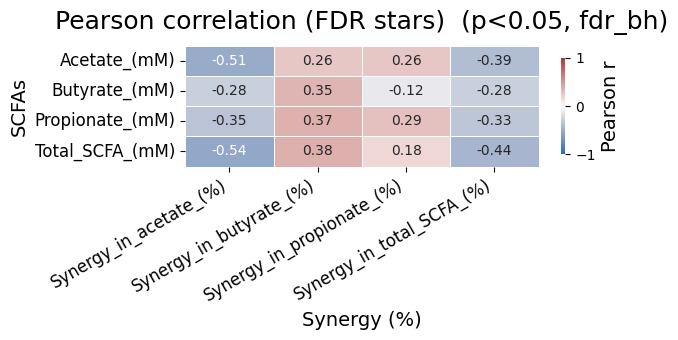

In [40]:
#@title ### Plot
#@markdown **How to use:**
#@markdown 1) Set the **file path** and your **Y (rows)** and **X (columns)**.
#@markdown 2) Tweak significance, masking, colors, **font sizes**, and export options.
#@markdown 3) (Optional) aggregate replicates (e.g., by `Individual`) before correlating.
#@markdown 4) Run to render and (optionally) save CSVs/figure.

# ===================== Input / selection =====================
file_path = "Metadata_V1.xlsx"  #@param {type:"string"}
y_cols = "Acetate_(mM), Butyrate_(mM), Propionate_(mM), Total_SCFA_(mM)"  #@param {type:"string"}
x_cols = "Synergy_in_acetate_(%), Synergy_in_butyrate_(%), Synergy_in_propionate_(%), Synergy_in_total_SCFA_(%)"  #@param {type:"string"}

# Optional pre-aggregation of replicates
groupby_cols = "Individual"  #@param {type:"string"}
agg_method = "mean"  #@param ["mean", "median"]

# ===================== Significance & annotation =====================
p_correction = "fdr_bh"  #@param ["none","fdr_bh","bonferroni","holm","sidak"]
p_thresh = 0.05  #@param {type:"slider", min:0.0, max:0.25, step:0.005}
annotate = "both"  #@param ["none","coef","stars","both"]
annot_decimals = 2  #@param {type:"slider", min:0, max:4, step:1}

from scipy.cluster.hierarchy import linkage, leaves_list
# ===================== Clustering options =====================
cluster_rows = False  #@param {type:"boolean"}
cluster_cols = False  #@param {type:"boolean"}

# ===================== Masking options =====================
mask_nonsignificant = False  #@param {type:"boolean"}
mask_upper_triangle = False  #@param {type:"boolean"}
mask_lower_triangle = False  #@param {type:"boolean"}
mask_diagonal = False  #@param {type:"boolean"}

# ===================== Plot appearance =====================
# Colormap list kept short; feel free to expand
cmap = "vlag"  #@param ["vlag","coolwarm","RdBu_r","viridis","magma","rocket","crest","icefire"]
fig_width = 6.5  #@param {type:"slider", min:4.0, max:20.0, step:0.5}
fig_height = 3.5  #@param {type:"slider", min:3.0, max:20.0, step:0.5}
vmin = -1  #@param {type:"slider", min:-1.0, max:0.0, step:0.05}
vmax = 1.0  #@param {type:"slider", min:0.0, max:1.0, step:0.05}
center_zero = True  #@param {type:"boolean"}
robust = False  #@param {type:"boolean"}
alpha = 1  #@param {type:"slider", min:0.1, max:1.0, step:0.05}
linewidths = 0.5  #@param {type:"slider", min:0.0, max:2.0, step:0.1}
linecolor = "white"  #@param ["white","black","#DDDDDD","#333333"]
square = False  #@param {type:"boolean"}

# ===================== Fonts & labels =====================
title_text = "Pearson correlation (FDR stars)"  #@param {type:"string"}
title_fontsize = 18  #@param {type:"slider", min:8, max:36, step:1}
axislabel_fontsize = 14  #@param {type:"slider", min:8, max:30, step:1}
ticklabel_fontsize = 12  #@param {type:"slider", min:6, max:26, step:1}
annot_fontsize = 10  #@param {type:"slider", min:6, max:26, step:1}
xtick_rotation = 30  #@param {type:"slider", min:0, max:90, step:5}
ytick_rotation = 0  #@param {type:"slider", min:-90, max:90, step:5}

# ===================== Colorbar =====================
show_colorbar = True  #@param {type:"boolean"}
cbar_label = "Pearson r"  #@param {type:"string"}
cbar_shrink = 0.8  #@param {type:"slider", min:0.4, max:1.0, step:0.05}
cbar_aspect = 20  #@param {type:"slider", min:5, max:40, step:1}
cbar_ticklabelsize = 10  #@param {type:"slider", min:6, max:26, step:1}

# ===================== Save outputs =====================
output_csv_prefix = ""  #@param {type:"string"}
savefig_path = "/content/"  #@param {type:"string"}
savefig_dpi = 300  #@param {type:"slider", min:72, max:600, step:4}
savefig_transparent = True  #@param {type:"boolean"}
tight_bbox = True  #@param {type:"boolean"}
savefig_svg = "Correlation heatmap between SCFA production and synergy in SCFA script.svg"  #@param {type:"string"}  # e.g., "/content/corr_heatmap.svg" (leave blank to skip)

# ===================== Implementation =====================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

def _parse_cols(s):
    return [re.sub(r'^[\'"]|[\'"]$', '', c.strip()) for c in s.split(",") if c.strip()]

def _star(p):
    if not np.isfinite(p):
        return ""
    return "****" if p < 1e-4 else \
           "***"  if p < 1e-3 else \
           "**"   if p < 1e-2 else \
           "*"    if p < 5e-2 else ""

def _correct_pvals(P, method):
    if method == "none":
        return P.copy()
    methods = {"fdr_bh":"fdr_bh", "bonferroni":"bonferroni", "holm":"holm", "sidak":"sidak"}
    arr = P.to_numpy().ravel()
    finite_mask = np.isfinite(arr)
    padj_all = np.full_like(arr, np.nan, dtype=float)
    _, padj, _, _ = multipletests(arr[finite_mask], method=methods[method])
    padj_all[finite_mask] = padj
    return pd.DataFrame(padj_all.reshape(P.shape), index=P.index, columns=P.columns)

def _aggregate(df, by, method, cols):
    keys = _parse_cols(by)
    if not keys:
        return df
    numeric = df[cols].apply(pd.to_numeric, errors='coerce')
    keep = df.drop(columns=cols).copy()
    df_num = pd.concat([keep, numeric], axis=1)
    if method.lower() == "median":
        out = df_num.groupby(keys, dropna=False).median(numeric_only=True).reset_index()
    else:
        out = df_num.groupby(keys, dropna=False).mean(numeric_only=True).reset_index()
    return out

# Load data
df = pd.read_excel(file_path)

# Select columns and (optional) aggregate
Y = _parse_cols(y_cols)
X = _parse_cols(x_cols)
missing = [c for c in (Y + X) if c not in df.columns]
if missing:
    raise KeyError(f"Columns not found in file: {missing}")

df_use = _aggregate(df.copy(), groupby_cols, agg_method, cols=X+Y)

# To numeric & drop NA
for c in X + Y:
    df_use[c] = pd.to_numeric(df_use[c], errors='coerce')
df_use = df_use.dropna(subset=X+Y, how='any')

# Compute r & p for all YxX
R = pd.DataFrame(index=Y, columns=X, dtype=float)
P = pd.DataFrame(index=Y, columns=X, dtype=float)
for yi in Y:
    for xj in X:
        xi = df_use[xj].to_numpy()
        yi_vals = df_use[yi].to_numpy()
        ok = np.isfinite(xi) & np.isfinite(yi_vals)
        xi = xi[ok]; yi_vals = yi_vals[ok]
        if xi.size >= 2 and np.std(xi) > 0 and np.std(yi_vals) > 0:
            r, p = pearsonr(xi, yi_vals)
        else:
            r, p = np.nan, np.nan
        R.loc[yi, xj] = r
        P.loc[yi, xj] = p

# Adjust p-values
P_adj = _correct_pvals(P, p_correction)

# Annotations
annot_df = False
if annotate != "none":
    annot_df = pd.DataFrame("", index=Y, columns=X, dtype=object)
    for yi in Y:
        for xj in X:
            cells = []
            if annotate in ("coef", "both"):
                r = R.loc[yi, xj]
                cells.append("NA" if not np.isfinite(r) else f"{r:.{annot_decimals}f}")
            if annotate in ("stars", "both"):
                p = P_adj.loc[yi, xj]
                cells.append("" if not np.isfinite(p) else _star(p))
            annot_df.loc[yi, xj] = "\n".join([c for c in cells if c != ""])

# Mask building
mask = np.zeros(R.shape, dtype=bool)
if mask_nonsignificant:
    mask |= ~(P_adj < p_thresh)
if mask_diagonal and len(set(X) & set(Y)) > 0:
    for i, yi in enumerate(Y):
        for j, xj in enumerate(X):
            if yi == xj:
                mask[i, j] = True
if mask_upper_triangle or mask_lower_triangle:
    n = min(len(Y), len(X))
    for i in range(len(Y)):
        for j in range(len(X)):
            if i < n and j < n:
                if mask_upper_triangle and j > i:
                    mask[i, j] = True
                if mask_lower_triangle and i > j:
                    mask[i, j] = True

# Optional Ward clustering
if cluster_rows and len(Y) > 1:
    row_linkage = linkage(R.fillna(0).values, method="ward")
    Y = [Y[i] for i in leaves_list(row_linkage)]

if cluster_cols and len(X) > 1:
    col_linkage = linkage(R.fillna(0).T.values, method="ward")
    X = [X[i] for i in leaves_list(col_linkage)]

# Reindex R, P, and annot if clustering applied
R = R.loc[Y, X]
P = P.loc[Y, X]
P_adj = P_adj.loc[Y, X]
if isinstance(annot_df, pd.DataFrame):
    annot_df = annot_df.loc[Y, X]

# Plot
plt.figure(figsize=(fig_width, fig_height))
ax = sns.heatmap(
    R.astype(float),
    vmin=vmin, vmax=vmax,
    cmap=cmap,
    center=0.0 if center_zero else None,
    robust=robust,
    square=square,
    annot=annot_df,
    annot_kws={"fontsize": annot_fontsize} if isinstance(annot_df, pd.DataFrame) else None,
    fmt="",
    cbar=show_colorbar,
    cbar_kws={"shrink": cbar_shrink, "aspect": cbar_aspect},
    linewidths=linewidths,
    linecolor=linecolor,
    alpha=alpha,
    mask=mask
)

x_label = "Synergy (%)"  #@param {type:"string"}
y_label = "SCFAs"  #@param {type:"string"}
ax.set_xlabel(x_label, fontsize=axislabel_fontsize)
ax.set_ylabel(y_label, fontsize=axislabel_fontsize)
sig_note = f"  (p<{p_thresh}, {p_correction})" if p_correction != "none" else "  (raw p)"
ax.set_title(title_text + sig_note, fontsize=title_fontsize, pad=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_rotation, ha="right", fontsize=ticklabel_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=ytick_rotation, va="center", fontsize=ticklabel_fontsize)

if show_colorbar and ax.collections:
    cb = ax.collections[0].colorbar
    cb.set_label(cbar_label, fontsize=axislabel_fontsize)
    cb.ax.tick_params(labelsize=cbar_ticklabelsize)

plt.tight_layout()

# Save image
if savefig_path.strip():
    plt.savefig(
        savefig_path,
        dpi=int(savefig_dpi),
        transparent=bool(savefig_transparent),
        bbox_inches="tight" if tight_bbox else None
    )

# Save SVG (optional)
if savefig_svg.strip():
    plt.savefig(
        savefig_svg,
        format="svg",
        transparent=bool(savefig_transparent),
        bbox_inches="tight" if tight_bbox else None
    )

plt.show()

# Save matrices
if output_csv_prefix.strip():
    R.to_csv(f"{output_csv_prefix}_R.csv")
    P.to_csv(f"{output_csv_prefix}_P_raw.csv")
    P_adj.to_csv(f"{output_csv_prefix}_P_adj_{p_correction}.csv")
    print(f"Saved CSVs with prefix '{output_csv_prefix}'")

## Figure S2

In [38]:
user = "ggaleano"  #@param {type:"string"}
install_dependencies = False  #@param {type:"boolean"}
# @markdown - You only check this box to run this the fist time.
qiime_working_directory = "/scratch/bell/ggaleano/coocurrence/family_level/Propionate_synergy/No_synergy/"  #@param {type:"string"}
imput_files_location = "/scratch/bell/ggaleano/coocurrence/family_level/"  #@param {type:"string"}
# @markdown - Imput your feature table and metadata here ⬆️
# @markdown - Example of [metadata](https://docs.google.com/spreadsheets/d/1-wPdeIyhaqFsRKwnbNOHMtiuoKm4dl8JYbpqTnPtUm8/edit?usp=sharing)
# @markdown - Example of [feature-table-mixture-family-level](https://drive.google.com/file/d/1w7VsHZo_xl2-GNlE-gPuZcGtxClNvtvy/view?usp=sharing)
filtering_formula = "[Propionate_synergy_category]='No_synergy'"  #@param {type:"string"}
correlation_method = "sparcc"  #@param ["spearman", "sparcc"]
p_val = 0.52  #@param {type:"slider", min:0.0, max:1.0, step:0.01}
# @markdown - Submit your output into Cytoscape.
correlation_metric = "r"  if correlation_method == "sparcc" else "p"
threshold = "min" if correlation_method == "sparcc" else "max"

method_clean = correlation_method.strip().lower()
is_sparcc = (method_clean == "sparcc")

sparcc_filter_block = (
    "# --- SparCC filter skipped for Spearman ---"
    if correlation_method == "spearman"
    else f"""qiime SCNIC sparcc-filter \\
  --i-table {qiime_working_directory}feature-table-filtered-low-abundances.qza \\
  --o-table-filtered {qiime_working_directory}feature-table-sparcc.qza"""
)

dependencies_block = (
    """# --- SparCC filter skipped for Spearman ---
    # Create fresh environment for QIIME2 2024.10
    wget https://data.qiime2.org/distro/amplicon/qiime2-amplicon-2024.10-py310-linux-conda.yml -O qiime2-amplicon.yml

    conda env create -n qiime2-scnic --file qiime2-amplicon.yml
    rm qiime2-amplicon.yml

    # Activate environment
    conda activate qiime2-scnic

    # Install SCNIC (Python package) and QIIME2 plugin
    pip install scnic==0.6.6
    pip install git+https://github.com/lozuponelab/q2-SCNIC.git

    # Register plugin
    qiime dev refresh-cache

    # Install FastSpar binary from Bioconda
    conda install -c bioconda fastspar -y"""
    if install_dependencies else """
    # Activate environment
    conda activate qiime2-scnic"""
)

# Choose the correct input table for correlations/modules
table_for_corr = (
    f"{qiime_working_directory}feature-table-sparcc.qza"
    if correlation_method == "sparcc" else
    f"{qiime_working_directory}feature-table-filtered-low-abundances.qza"
)

print(
f'''
ssh {user}@bell.rcac.purdue.edu
cd {qiime_working_directory}

# --- Transfer Data ---
scp metadata.tsv {user}@bell.rcac.purdue.edu:{qiime_working_directory}
scp feature-table.tsv {user}@bell.rcac.purdue.edu:{qiime_working_directory}

# --- Environment Setup ---

squeue -A hamakerb
sinteractive -A hamakerb -p cpu -t 2:00:00 -n10

module --force purge
module load biocontainers qiime2
module list

# --- Setting up SCNIC ---

module --force purge
module load conda

{dependencies_block}

# --- Convert and Import ---
biom convert \\
  -i {imput_files_location}feature-table.tsv \\
  --table-type="OTU table" \\
  --to-hdf5 \\
  -o {imput_files_location}feature-table.biom

qiime tools import \\
  --type 'FeatureTable[Frequency]' \\
  --input-format BIOMV210Format \\
  --input-path {imput_files_location}feature-table.biom \\
  --output-path {imput_files_location}feature-table.qza

# --- Filter samples by metadata ---
qiime feature-table filter-samples \\
  --i-table {imput_files_location}feature-table.qza \\
  --m-metadata-file {imput_files_location}metadata.tsv \\
  --p-where "{filtering_formula}" \\
  --o-filtered-table {qiime_working_directory}feature-table-filtered.qza

# --- Optional: remove low-abundance features ---
qiime feature-table filter-features \\
  --i-table {qiime_working_directory}feature-table-filtered.qza \\
  --p-min-frequency 10 \\
  --p-min-samples 2 \\
  --o-filtered-table {qiime_working_directory}feature-table-filtered-low-abundances.qza

# --- Run SCNIC Steps ---
{sparcc_filter_block}

# Correlations (use the correct table for the method)
qiime SCNIC calculate-correlations \\
  --i-table {table_for_corr} \\
  --p-method {correlation_method} \\
  --o-correlation-table {qiime_working_directory}correlations.qza

# Full network (pos + neg)
qiime SCNIC build-correlation-network-{correlation_metric} \\
  --i-correlation-table {qiime_working_directory}correlations.qza \\
  --p-{threshold}-val {p_val} \\
  --o-correlation-network {qiime_working_directory}Full_network_{filtering_formula}_{correlation_method}.qza

# Export full network to GML
qiime tools export \\
  --input-path {qiime_working_directory}Full_network_{filtering_formula}_{correlation_method}.qza \\
  --output-path {qiime_working_directory}network-exported-all-edges

# Download full network
scp -r {user}@bell.rcac.purdue.edu:{qiime_working_directory}network-exported-all-edges/network.gml .

# --- Module network (optional) ---
qiime SCNIC make-modules-on-correlations \\
  --i-correlation-table {qiime_working_directory}correlations.qza \\
  --i-feature-table {table_for_corr} \\
  --p-min-r 0.35 \\
  --o-collapsed-table {qiime_working_directory}collapsed.qza \\
  --o-correlation-network {qiime_working_directory}network-modules.qza \\
  --o-module-membership {qiime_working_directory}module-membership.qza

# Inspect module membership
qiime metadata tabulate \\
  --m-input-file {qiime_working_directory}module-membership.qza \\
  --o-visualization {qiime_working_directory}module-membership.qzv

# Export module-only network
qiime tools export \\
  --input-path {qiime_working_directory}network-modules.qza \\
  --output-path {qiime_working_directory}network-modules-export

# Download module network
scp -r {user}@bell.rcac.purdue.edu:{qiime_working_directory}network-modules-export/network.gml .

'''
)


ssh ggaleano@bell.rcac.purdue.edu
cd /scratch/bell/ggaleano/coocurrence/family_level/Propionate_synergy/No_synergy/

# --- Transfer Data ---
scp metadata.tsv ggaleano@bell.rcac.purdue.edu:/scratch/bell/ggaleano/coocurrence/family_level/Propionate_synergy/No_synergy/
scp feature-table.tsv ggaleano@bell.rcac.purdue.edu:/scratch/bell/ggaleano/coocurrence/family_level/Propionate_synergy/No_synergy/

# --- Environment Setup ---

squeue -A hamakerb
sinteractive -A hamakerb -p cpu -t 2:00:00 -n10

module --force purge
module load biocontainers qiime2
module list

# --- Setting up SCNIC ---

module --force purge
module load conda


    # Activate environment
    conda activate qiime2-scnic

# --- Convert and Import ---
biom convert \
  -i /scratch/bell/ggaleano/coocurrence/family_level/feature-table.tsv \
  --table-type="OTU table" \
  --to-hdf5 \
  -o /scratch/bell/ggaleano/coocurrence/family_level/feature-table.biom

qiime tools import \
  --type 'FeatureTable[Frequency]' \
  --input-format